In [ ]:
import glob

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import read as read_xyz
from ase.visualize import view
from dscribe.descriptors import SOAP

import shap
from umap import UMAP
from xgboost import XGBRegressor
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import silhouette_score

## Data Loading

In [2]:
file_paths = glob.glob("../data/*.xyz")
structures = [read_xyz(x) for x in file_paths]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

len(structures)

999

In [3]:
idx_lowest = np.argmin(energy_levels)
idx_lowest, file_paths[idx_lowest]

(np.int64(622), '../data/350.xyz')

In [ ]:
view(structures[idx_lowest], viewer='x3d')

## SOAP Feature Extraction

In [4]:
soap = SOAP(
    r_cut=5,
    n_max=8,
    l_max=8,
    species=["Au"],
    average="outer",
    periodic=False,
    sparse=False,
)

soap

In [5]:
X = soap.create(structures, n_jobs=2).reshape(999, -1)
X.shape

(999, 324)

In [6]:
energy_levels_norm = MinMaxScaler().fit_transform(energy_levels.reshape(-1, 1)).flatten() * 50
energy_levels_norm.shape

(999,)

## Modelling

In [7]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [8]:
model = XGBRegressor(random_state=21)
model.fit(X_pca, energy_levels)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
explainer = shap.TreeExplainer(model)
explanations = explainer(X_pca)

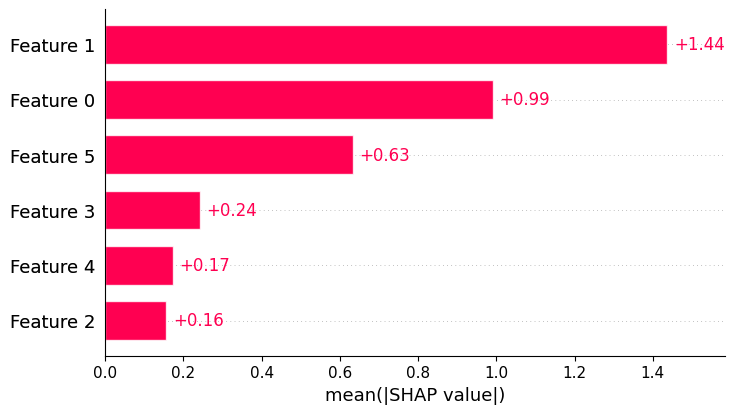

In [10]:
shap.plots.bar(explanations)

## Dimension Reduction

In [ ]:
umap_shap = UMAP(n_components=2, min_dist=0, n_neighbors=20)
umap_shap_data = umap_shap.fit_transform(explanations.values)

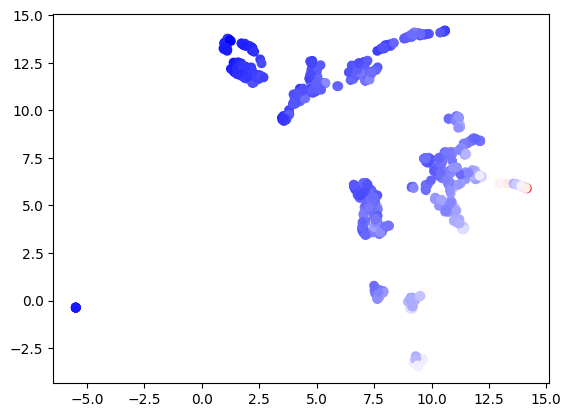

In [12]:
plt.scatter(umap_shap_data[:, 0], umap_shap_data[:, 1], c=energy_levels_norm, cmap="bwr")

## Clustering Parameter Search

In [161]:
param_grid = {
    "eps": np.arange(0.1, 2.0, 0.1),
    "min_samples": np.arange(10, 50, 5),
}

param_list = list(ParameterSampler(param_grid, n_iter=param_grid["eps"].shape[0] * param_grid["min_samples"].shape[0]))

In [162]:
silhouette_scores = []
for param in param_list:
    cluster_labels = DBSCAN(**param).fit_predict(umap_shap_data)
    if len(set(cluster_labels)) == 1:
        continue
    
    silhouette_avg = silhouette_score(umap_shap_data, cluster_labels)
    silhouette_scores.append({"score": silhouette_avg, "num_clusters": len(set(cluster_labels)), **param})

df_scores = pd.DataFrame(silhouette_scores)
df_scores.sort_values("score", ascending=False).head()

,score,num_clusters,min_samples,eps
11,0.611304,19,10,0.4
6,0.603684,26,10,0.3
12,0.584646,21,15,0.4
21,0.577936,20,25,0.5
19,0.571626,14,15,0.5


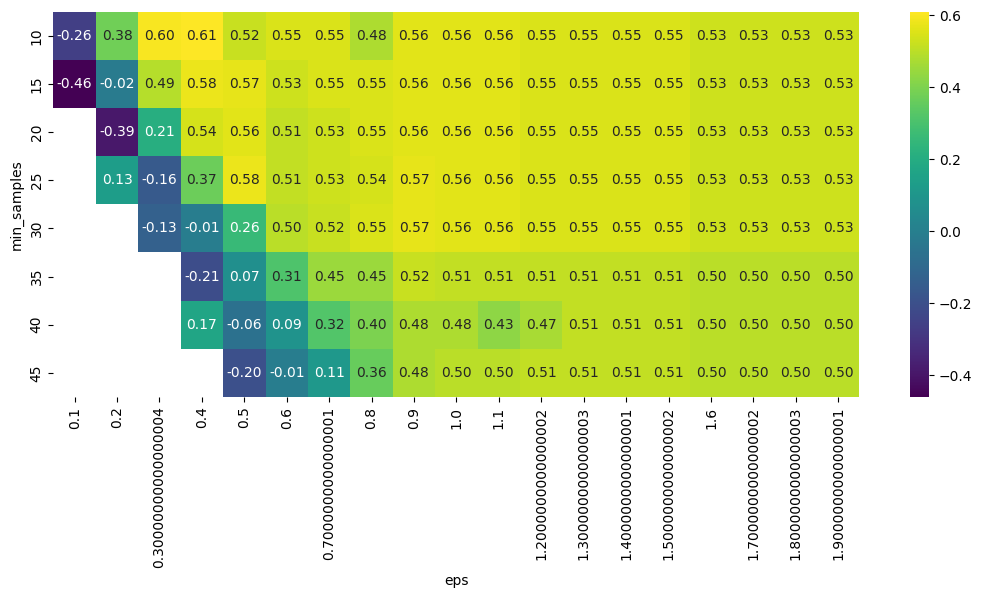

In [163]:
fig, ax = plt.subplots(figsize=(13, 5))

dd = df_scores.pivot_table(index="min_samples", columns="eps", values="score").round(2)
sns.heatmap(dd, annot=True, fmt=".2f", cmap="viridis", ax=ax)

plt.show()

## Clustering

In [164]:
dbs = DBSCAN(eps=0.9, min_samples=22)
dbs.fit(umap_shap_data)

,eps,0.9
,min_samples,22
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


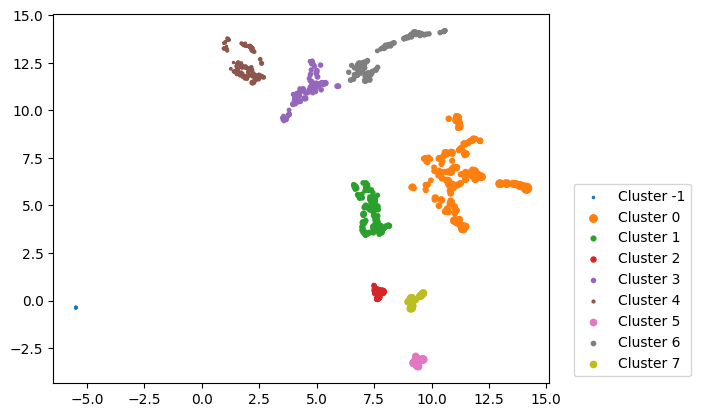

In [165]:
fig, ax = plt.subplots()

for cluster in list(sorted(set(dbs.labels_))):
    ax.scatter(
        x=umap_shap_data[:, 0][dbs.labels_ == cluster], 
        y=umap_shap_data[:, 1][dbs.labels_ == cluster], 
        s=energy_levels_norm[dbs.labels_ == cluster],
        label=f"Cluster {cluster}",
    )

plt.legend(loc="lower right", bbox_to_anchor=(1.3, 0))
plt.show()

<Axes: xlabel='cluster', ylabel='energy'>

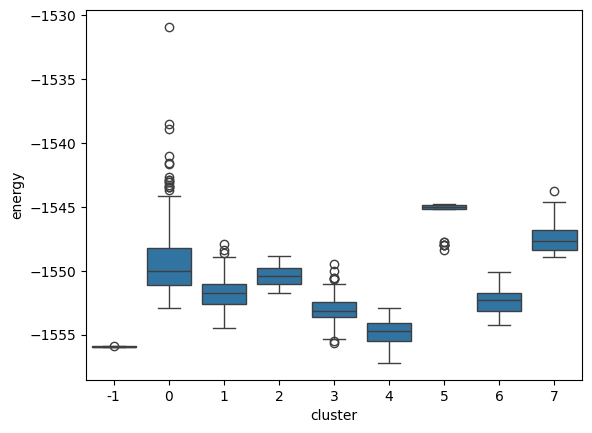

In [ ]:
df_energy = pd.DataFrame({
    "cluster": dbs.labels_,
    "energy": energy_levels,
    "file_paths": file_paths,
})

sns.boxplot(df_energy, x="cluster", y="energy")